In [1]:
! pip install tensorflow_model_optimization

     |████████████████████████████████| 241 kB 7.9 MB/s 
     |████████████████████████████████| 240 kB 60.1 MB/s 
     |████████████████████████████████| 238 kB 92.7 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Importing Libraries
import os
import numpy as np
import pandas as pd

from PIL import Image
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pydot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from IPython.display import display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_model_optimization as tfmot
import keras.utils
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

import itertools

import cv2
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
# Setting data directory
data_directory = os.path.join("/kaggle/input/", "skin-cancer-mnist-ham10000/")
os.listdir(data_directory)

['hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv']

In [4]:
# Loading HAM10000_meatdata.csv 
data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))

In [5]:
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
7877,HAM_0002431,ISIC_0033294,nv,histo,25.0,male,lower extremity
9767,HAM_0006135,ISIC_0031044,akiec,histo,60.0,male,face
4734,HAM_0003416,ISIC_0030379,nv,follow_up,40.0,male,lower extremity
6941,HAM_0006484,ISIC_0028527,nv,histo,55.0,female,upper extremity
1780,HAM_0005249,ISIC_0032526,mel,histo,40.0,female,lower extremity


In [6]:
# Creating dictionary for image path, and lesion type
# Adding images from both the folders
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_directory, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [7]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [8]:
%%time
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

CPU times: user 1min 38s, sys: 1.97 s, total: 1min 40s
Wall time: 2min 52s


In [9]:
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
3823,HAM_0001005,ISIC_0028058,nv,follow_up,55.0,female,trunk,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[241, 152, 169], [242, 154, 171], [240, 151,..."
9854,HAM_0002441,ISIC_0031381,akiec,histo,80.0,male,scalp,Actinic keratoses (akiec),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[194, 96, 124], [201, 97, 123], [206, 102, 1..."
8477,HAM_0006983,ISIC_0026147,nv,histo,30.0,female,upper extremity,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[134, 109, 82], [143, 120, 95], [146, 120, 9..."
5594,HAM_0002884,ISIC_0028251,nv,follow_up,55.0,female,lower extremity,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[209, 116, 136], [209, 117, 138], [206, 114,..."
243,HAM_0007341,ISIC_0033758,bkl,histo,50.0,female,lower extremity,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[68, 52, 67], [106, 88, 105], [134, 116, 133..."


In [10]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=data['sex'].value_counts().index, 
            y=data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=data['localization'].value_counts().index, 
            y=data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=data['dx'].value_counts().index.map(lesion_type_dict.get), 
            y=data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data', height=800)

fig.show()


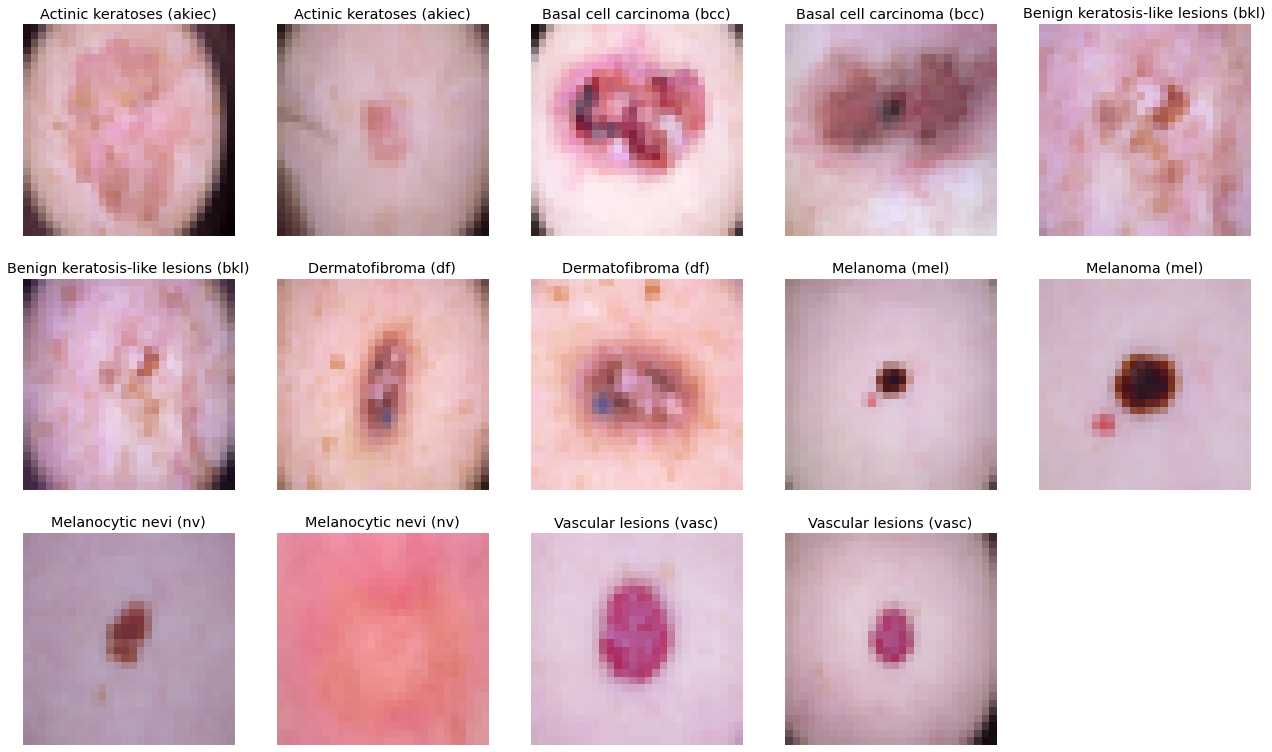

In [11]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show()

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   cell_type     10015 non-null  object 
 8   path          10015 non-null  object 
 9   image_pixel   10015 non-null  object 
dtypes: float64(1), object(9)
memory usage: 782.5+ KB


In [13]:
# Checking null values
data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
cell_type        0
path             0
image_pixel      0
dtype: int64

In [14]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [15]:
# Categorically encoding label of the images 
data['label'] = data['dx'].map(reverse_label_mapping.get)

In [16]:
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
1584,HAM_0005758,ISIC_0033286,mel,histo,85,male,chest,Melanoma (mel),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[17, 7, 13], [58, 33, 51], [123, 93, 126], [...",1
7796,HAM_0001667,ISIC_0033080,nv,histo,60,male,trunk,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[167, 158, 177], [167, 159, 177], [170, 163,...",0
6237,HAM_0006688,ISIC_0030699,nv,follow_up,50,male,abdomen,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[246, 171, 199], [247, 171, 201], [247, 173,...",0
93,HAM_0004852,ISIC_0028774,bkl,histo,65,male,face,Benign keratosis-like lesions (bkl),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[134, 93, 100], [138, 96, 103], [139, 93, 87...",2
7941,HAM_0002325,ISIC_0033835,nv,histo,45,male,abdomen,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[158, 133, 157], [165, 142, 166], [171, 149,...",0


In [17]:
data = data.sort_values('label')
data = data.reset_index()

In [18]:
%%time
index1 = data[data['label'] == 1].index.values
index2 = data[data['label'] == 2].index.values
index3 = data[data['label'] == 3].index.values
index4 = data[data['label'] == 4].index.values
index5 = data[data['label'] == 5].index.values
index6 = data[data['label'] == 6].index.values

df_index1 = data.iloc[int(min(index1)):int(max(index1)+1)]
df_index2 = data.iloc[int(min(index2)):int(max(index2)+1)]
df_index3 = data.iloc[int(min(index3)):int(max(index3)+1)]
df_index4 = data.iloc[int(min(index4)):int(max(index4)+1)]
df_index5 = data.iloc[int(min(index5)):int(max(index5)+1)]
df_index6 = data.iloc[int(min(index6)):int(max(index6)+1)]

df_index1 = df_index1.append([df_index1]*4, ignore_index = True)
df_index2 = df_index2.append([df_index2]*4, ignore_index = True)
df_index3 = df_index3.append([df_index3]*11, ignore_index = True)
df_index4 = df_index4.append([df_index4]*17, ignore_index = True)
df_index5 = df_index5.append([df_index5]*45, ignore_index = True)
df_index6 = df_index6.append([df_index6]*52, ignore_index = True)

frames = [data, df_index1, df_index2, df_index3, df_index4, df_index5, df_index6]
final_data = pd.concat(frames)

CPU times: user 141 ms, sys: 8.5 ms, total: 150 ms
Wall time: 156 ms


In [19]:
%%time
print(data.shape)
print(final_data.shape)

(10015, 12)
(45756, 12)
CPU times: user 145 µs, sys: 4 µs, total: 149 µs
Wall time: 139 µs


In [20]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=final_data['sex'].value_counts().index, 
            y=final_data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=final_data['localization'].value_counts().index, 
            y=final_data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=final_data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=final_data['dx'].value_counts().index.map(lesion_type_dict.get), 
            y=final_data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data after augmentation', height=800)

fig.show()

In [21]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [22]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


In [23]:
%%time
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
#     tf.keras.utils.plot_model(model, to_file="model.png")
    return model;

def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto', restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history
    
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()
    
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.3 µs


In [24]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

In [25]:
model1 = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         7

In [26]:
model1_history = train_model(model1, X_train_orig, Y_train_orig, 50)

Epoch 1/50
101/101 [==============================] - 5s 13ms/step - loss: 4.5954 - accuracy: 0.5510 - val_loss: 0.9851 - val_accuracy: 0.6687
Epoch 2/50
101/101 [==============================] - 0s 4ms/step - loss: 0.9911 - accuracy: 0.6630 - val_loss: 0.9756 - val_accuracy: 0.6706
Epoch 3/50
101/101 [==============================] - 0s 4ms/step - loss: 0.9256 - accuracy: 0.6765 - val_loss: 0.9593 - val_accuracy: 0.6650
Epoch 4/50
101/101 [==============================] - 0s 4ms/step - loss: 0.9296 - accuracy: 0.6770 - val_loss: 0.9108 - val_accuracy: 0.6775
Epoch 5/50
101/101 [==============================] - 0s 4ms/step - loss: 0.8403 - accuracy: 0.6997 - val_loss: 0.8555 - val_accuracy: 0.6987
Epoch 6/50
101/101 [==============================] - 0s 4ms/step - loss: 0.8182 - accuracy: 0.7117 - val_loss: 0.9231 - val_accuracy: 0.6837
Epoch 7/50
101/101 [==============================] - 0s 4ms/step - loss: 0.8154 - accuracy: 0.7137 - val_loss: 0.7951 - val_accuracy: 0.7093
Epoch

In [27]:
plot_model_training_curve(model1_history)

Test Accuracy: 74.488%


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

          nv       0.88      0.88      0.88      1374
         mel       0.47      0.40      0.43       205
         bkl       0.45      0.48      0.46       227
         bcc       0.40      0.68      0.51        94
       akiec       0.41      0.25      0.31        55
        vasc       0.87      0.71      0.78        28
          df       0.00      0.00      0.00        20

    accuracy                           0.74      2003
   macro avg       0.50      0.49      0.48      2003
weighted avg       0.74      0.74      0.74      2003



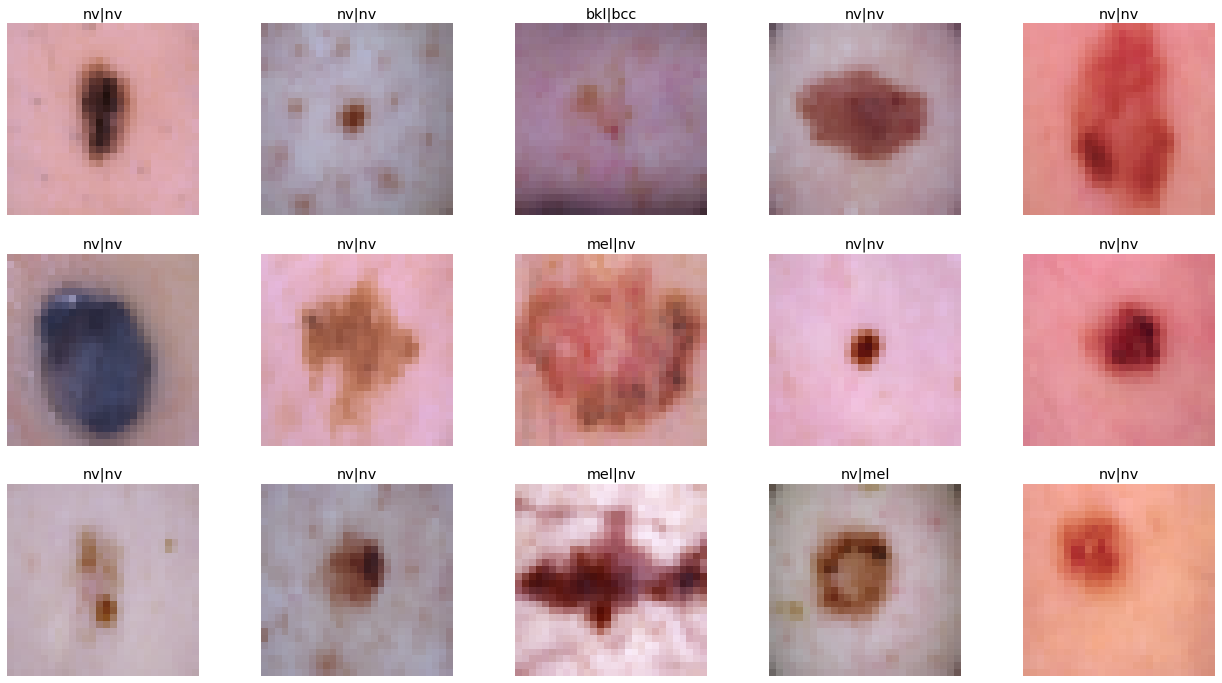

In [28]:
test_model(model1, X_test_orig, Y_test_orig)

In [29]:
# For Augmented Dataset
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [30]:
model2 = create_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)        

In [31]:
model2_history = train_model(model2, X_train_aug, Y_train_aug, 50)

Epoch 1/50
458/458 [==============================] - 2s 4ms/step - loss: 2.6982 - accuracy: 0.3351 - val_loss: 1.0316 - val_accuracy: 0.6058
Epoch 2/50
458/458 [==============================] - 2s 4ms/step - loss: 0.9271 - accuracy: 0.6483 - val_loss: 0.6525 - val_accuracy: 0.7506
Epoch 3/50
458/458 [==============================] - 2s 4ms/step - loss: 0.6137 - accuracy: 0.7680 - val_loss: 0.4877 - val_accuracy: 0.8250
Epoch 4/50
458/458 [==============================] - 2s 4ms/step - loss: 0.4548 - accuracy: 0.8329 - val_loss: 0.3664 - val_accuracy: 0.8715
Epoch 5/50
458/458 [==============================] - 2s 4ms/step - loss: 0.3062 - accuracy: 0.8897 - val_loss: 0.2786 - val_accuracy: 0.9032
Epoch 6/50
458/458 [==============================] - 2s 4ms/step - loss: 0.2480 - accuracy: 0.9105 - val_loss: 0.3366 - val_accuracy: 0.8758
Epoch 7/50
458/458 [==============================] - 2s 4ms/step - loss: 0.2524 - accuracy: 0.9072 - val_loss: 0.2961 - val_accuracy: 0.8974
Epoch 

In [32]:
plot_model_training_curve(model2_history)

Test Accuracy: 97.618%
              precision    recall  f1-score   support

          nv       0.99      0.85      0.92      1385
         mel       0.93      0.99      0.96      1328
         bkl       0.95      1.00      0.97      1294
         bcc       0.99      1.00      0.99      1325
       akiec       1.00      1.00      1.00      1270
        vasc       1.00      1.00      1.00      1293
          df       1.00      1.00      1.00      1257

    accuracy                           0.98      9152
   macro avg       0.98      0.98      0.98      9152
weighted avg       0.98      0.98      0.98      9152



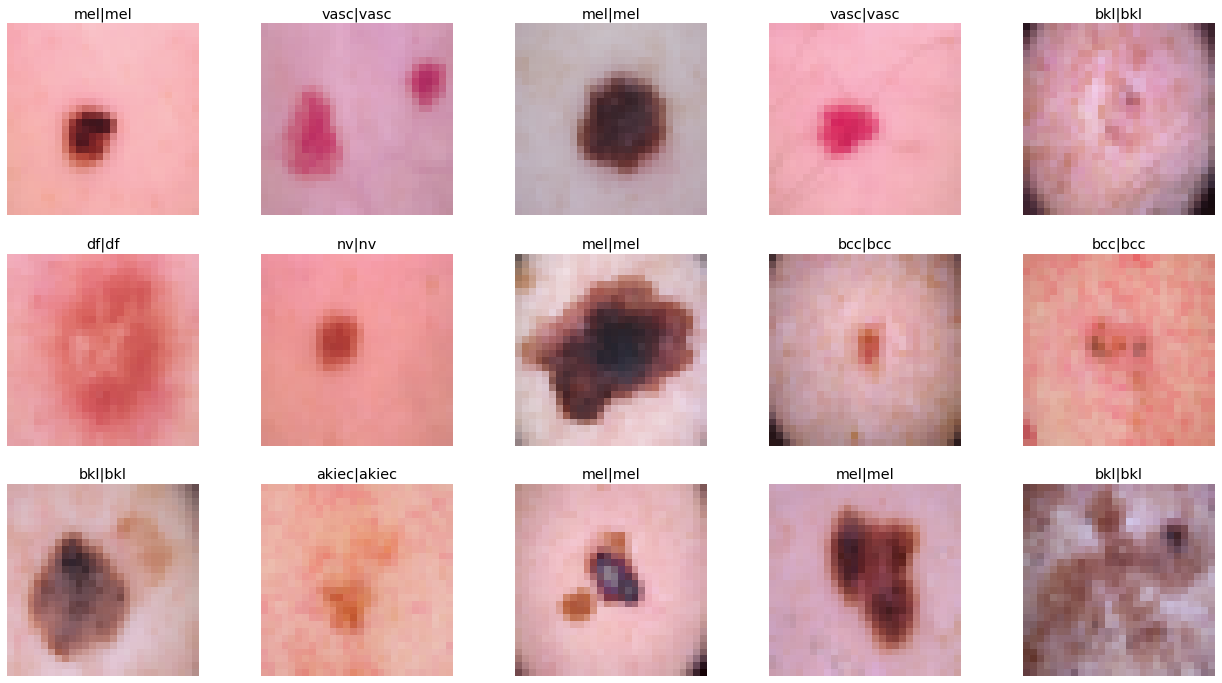

In [33]:
test_model(model2, X_test_aug, Y_test_aug)

In [34]:
from keras.models import load_model

model2.save('model2.h5')

In [35]:
import tensorflow as tf
model2 = tf.keras.models.load_model('model2.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()
open("model2.tflite", "wb").write(tflite_model)

535272

In [36]:
from tensorflow.contrib import lite
from tensorflow.python.framework import tensor_util
def is_tensor(x):                                                                                                                                                      
    return tensor_util.is_tensor(x)
converter = lite.TFLiteConverter.from_keras_model_file( 'model2.h5')
tfmodel = converter.convert()
open ("model2.tflite" , "wb") .write(tfmodel)

ModuleNotFoundError: No module named 'tensorflow.contrib'